# SuperGradients Model

In this notebook I use the SuperGradients library, an open-source neural network, to train my model. It uses standard pyTorch models and build upon them for higher accuracy. Once again we pick a model with proven high accuracy and which should be a good fit for our problem. 

***NOTE! This notebook and model training was all run on Kaggle and/or SaturnCloud with heavy GPU augmentation, and took up to two hours to run. I would recommend loading the notebooks onto SaturnCloud to run them.***

### Basic Imports and Setup

In [1]:
!pip install super_gradients==3.0.0 gwpy &> /dev/null

!pip install albumentations  &> /dev/null

In [2]:
import os
import numpy as np 
import pandas as pd
import torch
import torchvision
import super_gradients
from pathlib import Path, PurePath

from PIL import Image
import pprint
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision.transforms import Resize
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from super_gradients import init_trainer, Trainer
from super_gradients.common import MultiGPUMode
from super_gradients.training.utils.distributed_training_utils import setup_gpu_mode
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams

from super_gradients.training import models
from super_gradients import Trainer

You did not mention an AWS environment.You can set the environment variable ENVIRONMENT_NAME with one of the values: development,staging,production
deci_platform_sg_logger -WARNING- Failed to import deci_lab_client
callbacks -WARNING- Failed to import deci_lab_client
quantization_utils -WARNING- Failed to import pytorch_quantization
env_sanity_check -INFO- ** A sanity check is done when importing super_gradients for the first time. **
-> You can see the details by setting the env variable DISPLAY_SANITY_CHECK=True prior to import.


### Configurations

This class makes it easier to adjust parameter values. We only need to change them here and it will automatically reflect wherever they are called.

In [3]:
class config:
    EXPERIMENT_NAME = 'kitchenware_classification'
    MODEL_NAME = 'vit_large'
    CHECKPOINT_DIR = 'checkpoints'
    WEIGHTS = "imagenet"
    TRAINING_PARAMS = "training_hyperparams/imagenet_vit_train_params"
    NUM_CLASSES = 6
    BATCH_SIZE = 16

    # specify the paths to training and validation set 
    IMAGE_PATH = './data/images'
    TRAIN_DATA = './data/train.csv'
    TEST_DATA = './data/test.csv'

    

    # set the input height and width
    INPUT_HEIGHT = 224
    INPUT_WIDTH = 224

    # set the input height and width
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    NUM_WORKERS = os.cpu_count()

    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### SG Trainer, model, and training params

Here we define a trainer, choose the model, and specify training parameters that help tune the model to our needs.


In [4]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

model = models.get(model_name=config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained_weights=config.WEIGHTS)

Downloading: "https://deci-pretrained-models.s3.amazonaws.com/vit_large_cutmix_randaug_v2_lr%3D0.03/average_model.pth" to /root/.cache/torch/hub/checkpoints/vit_large_cutmix_randaug_v2_lr%3D0.03_average_model.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

In [5]:
training_params =  training_hyperparams.get(config.TRAINING_PARAMS)


/opt/conda/lib/python3.7/site-packages/super_gradients/training/training_hyperparams/training_hyperparams.py:24: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=pkg_resources.resource_filename("super_gradients.recipes", "")):
/opt/conda/lib/python3.7/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/imagenet_vit_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


(You can get a detailed description of what all these mean and available options by going [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).)

In [6]:
training_params["max_epochs"] = 5
training_params["zero_weight_decay_on_bias_and_bn"] = True
training_params['train_metrics_list'] = ['Accuracy']
training_params['valid_metrics_list'] = ['Accuracy']
training_params['ema'] = True
training_params["criterion_params"] = {'smooth_eps': 0.1} 
training_params['average_best_models'] = True
training_params["sg_logger_params"]["launch_tensorboard"] = False


### Data setup

Here we add a column into the dataframes which link them to the images themselves provided in a seperate folder. We also split the training data for validation. The test dataset is provided seperately from the Kaggle source. We use the training dataset for both training and validation purposes.

In [7]:
def add_image_col(df):
    df['image'] = df['Id'].apply(lambda x: x +'.jpg')
    
# read labels into pandas df all cols as string
labels_df = pd.read_csv(config.TRAIN_DATA, dtype='str')
test_df = pd.read_csv(config.TEST_DATA, dtype='str')

# create col (xxxx.jpg), the image filename
add_image_col(labels_df)
add_image_col(test_df)

# map labels to integer
le = LabelEncoder()
labels_df['targets'] = le.fit_transform(labels_df['label'])

#split into train and validation sets
train_df, val_df = train_test_split(labels_df,  stratify= labels_df['targets'], test_size=.10, shuffle=True, random_state=42)

# number of samples in each
train_df.shape[0] , val_df.shape[0], test_df.shape[0]

(5003, 556, 3808)

This class is used to load in the data with augmentations.

In [8]:
class KitchwareDataset(Dataset):
    def __init__(self, dataframe , img_dir, split, transform = None):
        self.img_labels = dataframe 
        self.img_dir = img_dir
        self.split = split
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self , idx):
        if self.split in ['train', 'val']:
            img_path = os.path.join(self.img_dir , self.img_labels.iloc[idx, 2])
            label = self.img_labels.iloc[idx, 3]
        else:
            img_path = os.path.join(self.img_dir , self.img_labels.iloc[idx, 1])
            
        original_image = Image.open(img_path)
        image = np.array(original_image)
        
        if self.transform:
            image = self.transform(image=image)['image']
            
        if self.split in ['train', 'val']: 
            return image, label 
        else:
            return image

### Transformations

Here we detail out which transformations to perform for augmentation purposes. These can then be passed easily into the class defined above, so we don't have to individually apply them all. 

In [9]:
# initialize our data augmentation functions
make_tensor = ToTensorV2()

normalize = A.Normalize(mean=config.IMAGENET_MEAN, 
                        std=config.IMAGENET_STD)

resize = A.Resize(height=config.INPUT_HEIGHT,
                  width=config.INPUT_WIDTH)

horizontal_flip = A.HorizontalFlip(p=0.50)

flip = A.Flip(p=0.50)

random_ninety = A.RandomRotate90()

random_crop = A.RandomCrop(height=config.INPUT_HEIGHT,
                           width=config.INPUT_WIDTH,
                           p=0.75)

hue_saturation = A.HueSaturationValue(p=.5)

iso_noise = A.ISONoise(p=.5)

color_jitter = A.ColorJitter(p=.5)

emboss = A.Emboss(p=.5)

channel_shuffle = A.ChannelShuffle(p=.5)

randomly_choose_one = A.OneOf([flip, 
                               random_ninety, 
                               iso_noise,
                               color_jitter,
                               emboss,
                               hue_saturation,
                               channel_shuffle], p=.50)

# initialize our training and validation set data augmentation pipeline
train_transforms = A.Compose([
  resize, 
  horizontal_flip, 
  random_crop,
  randomly_choose_one,
  normalize,
  make_tensor
])

val_transforms = A.Compose([resize, normalize, make_tensor])

This generates the actual data, applying augmentation for training and preprocessing only for validation and test. 

In [10]:
train_data = KitchwareDataset(train_df , config.IMAGE_PATH , 'train', transform = train_transforms)
val_data = KitchwareDataset(val_df , config.IMAGE_PATH , 'val', transform = val_transforms)
test_data = KitchwareDataset(test_df, config.IMAGE_PATH, 'test',transform = val_transforms)

train_dataloader = DataLoader(train_data, batch_size = config.BATCH_SIZE , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = config.BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = config.BATCH_SIZE, shuffle = False)

Taking a quick look at the training data.

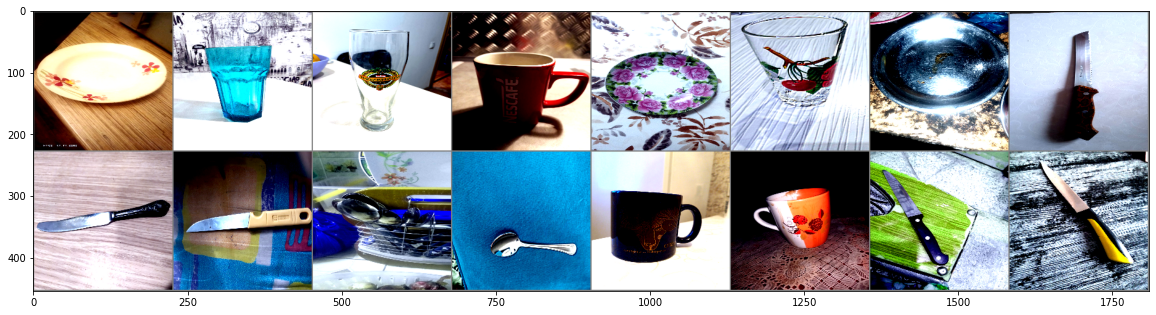

In [11]:
def show_img(img):
    plt.figure(figsize=(20,16))
    img = img * 0.5 + 0.5  
    npimg = np.clip(img.numpy(), 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data = iter(train_dataloader)
images, labels = data.next()
show_img(torchvision.utils.make_grid(images))

### Model Training

This sets the model to train on our own dataset. 

**This step takes a long time to run even with GPU accelaration, would not recommend running without GPU**

In [12]:
trainer.train(model=model, 
              training_params=training_params, 
              train_loader=train_dataloader,
              valid_loader=val_dataloader)

sg_trainer -INFO- Using EMA with params {'decay': 0.9999, 'beta': 15, 'exp_activation': True}
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive modules, this bias parameter will be part of param group with zero weight decay.
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive modules, this bias parameter will be part of param group with zero weight decay.
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive modules, this bias parameter will be part of param group with zero weight decay.
optimizer_utils -WARNING- Module class: <class 'torch.nn.modules.normalization.LayerNorm'>, have a `bias` parameter attribute but is not instance of torch primitive mod

Train epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:386: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
Validation epoch 0: 100%|██████████| 35/35 [00:21<00:00,  1.64it/s]


SUMMARY OF EPOCH 0
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.5209
└── Validation
    ├── Accuracy = 0.9784
    └── Labelsmoothingcrossentropyloss = 0.4768

base_sg_logger -INFO- Checkpoint saved in checkpoints/kitchenware_classification/ckpt_best.pth
sg_trainer -INFO- Best checkpoint overriden: validation Accuracy: 0.9784172773361206


Validation epoch 1: 100%|██████████| 35/35 [00:21<00:00,  1.64it/s]


SUMMARY OF EPOCH 1
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.4709
│       ├── Best until now = 0.5209 (↘ -0.05)
│       └── Epoch N-1      = 0.5209 (↘ -0.05)
└── Validation
    ├── Accuracy = 0.9766
    │   ├── Best until now = 0.9784 (↘ -0.0018)
    │   └── Epoch N-1      = 0.9784 (↘ -0.0018)
    └── Labelsmoothingcrossentropyloss = 0.4767
        ├── Best until now = 0.4768 (↘ -0.0)
        └── Epoch N-1      = 0.4768 (↘ -0.0)



Validation epoch 2: 100%|██████████| 35/35 [00:21<00:00,  1.66it/s]


SUMMARY OF EPOCH 2
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.448
│       ├── Best until now = 0.4709 (↘ -0.0229)
│       └── Epoch N-1      = 0.4709 (↘ -0.0229)
└── Validation
    ├── Accuracy = 0.9784
    │   ├── Best until now = 0.9784 (↘ 0.0)
    │   └── Epoch N-1      = 0.9766 (↗ 0.0018)
    └── Labelsmoothingcrossentropyloss = 0.473
        ├── Best until now = 0.4767 (↘ -0.0037)
        └── Epoch N-1      = 0.4767 (↘ -0.0037)



Validation epoch 3: 100%|██████████| 35/35 [00:21<00:00,  1.65it/s]


SUMMARY OF EPOCH 3
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.431
│       ├── Best until now = 0.448  (↘ -0.017)
│       └── Epoch N-1      = 0.448  (↘ -0.017)
└── Validation
    ├── Accuracy = 0.9784
    │   ├── Best until now = 0.9784 (↘ 0.0)
    │   └── Epoch N-1      = 0.9784 (↘ 0.0)
    └── Labelsmoothingcrossentropyloss = 0.4725
        ├── Best until now = 0.473  (↘ -0.0005)
        └── Epoch N-1      = 0.473  (↘ -0.0005)



Validation epoch 4: 100%|██████████| 35/35 [00:20<00:00,  1.69it/s]


SUMMARY OF EPOCH 4
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.4278
│       ├── Best until now = 0.431  (↘ -0.0031)
│       └── Epoch N-1      = 0.431  (↘ -0.0031)
└── Validation
    ├── Accuracy = 0.9784
    │   ├── Best until now = 0.9784 (↘ 0.0)
    │   └── Epoch N-1      = 0.9784 (↘ 0.0)
    └── Labelsmoothingcrossentropyloss = 0.4719
        ├── Best until now = 0.4725 (↘ -0.0007)
        └── Epoch N-1      = 0.4725 (↘ -0.0007)

sg_trainer -INFO- RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...


Validation epoch 5: 100%|██████████| 35/35 [00:21<00:00,  1.65it/s]


SUMMARY OF EPOCH 5
├── Training
│   └── Labelsmoothingcrossentropyloss = 0.4278
│       ├── Best until now = 0.431  (↘ -0.0031)
│       └── Epoch N-1      = 0.431  (↘ -0.0031)
└── Validation
    ├── Accuracy = 0.982
    │   ├── Best until now = 0.9784 (↗ 0.0036)
    │   └── Epoch N-1      = 0.9784 (↗ 0.0036)
    └── Labelsmoothingcrossentropyloss = 0.467
        ├── Best until now = 0.4719 (↘ -0.0049)
        └── Epoch N-1      = 0.4719 (↘ -0.0049)



In [13]:
# Load the best model that we trained
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(trainer.checkpoints_dir_path, "ckpt_best.pth"))

At this point our best model has an accuracy of 98%. This is signifcantly better than the other models we trained in `02_fastai_model.ipynb`, so this is what we will go forward and use. See `04_train.ipynb` for saving and exporting the model.